<a href="https://colab.research.google.com/github/kutluhanNG/MachineLearning/blob/main/Progressive_Growing_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Utility Layers:**
* PixelNormalization scales features at each pixel to unit norm.
* MinibatchStdDev computes a simple statistic over the batch and appends it as an extra feature map.
* upsample and downsample functions change the spatial resolution.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

# ---------------------------
# Utility Layers and Functions
# ---------------------------

class PixelNormalization(layers.Layer):
    """
    Normalizes each pixel vector (across channels) to unit length.
    """
    def __init__(self, epsilon=1e-8, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)


class MinibatchStdDev(layers.Layer):
    """
    Adds a minibatch standard deviation feature map.
    """
    def call(self, inputs):
        # Compute standard deviation over the batch
        mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
        std = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
        mean_std = tf.reduce_mean(std, keepdims=True)
        shape = tf.shape(inputs)

        # Tile to have one extra channel
        output = tf.tile(mean_std, [shape[0], shape[1], shape[2], 1])
        return tf.concat([inputs, output], axis=-1)


def upsample(x):
    """Upsamples feature maps by a factor of 2 using nearest neighbor."""
    new_size = (x.shape[1] * 2, x.shape[2] * 2)
    return tf.image.resize(x, new_size, method='nearest')


def downsample(x):
    """Downsamples feature maps by a factor of 2 using average pooling."""
    return tf.nn.avg_pool2d(x, ksize=2, strides=2, padding='SAME')

**Generator:**
* The generator starts by mapping a latent vector to a 4×4 feature map.
* It then passes through a series of blocks; each new block is “faded in” using the parameter alpha so that when transitioning to a higher resolution, the output is a blend of the new (higher‐resolution) branch and the upsampled previous branch.
* The final “to_rgb” convolution converts feature maps to a three–channel image.

In [2]:
# ---------------------------
# Progressive Generator
# ---------------------------

class ProgressiveGenerator(tf.keras.Model):
    def __init__(self, latent_dim, num_steps=4, **kwargs):
        """
        Args:
            latent_dim: Dimension of the latent input vector.
            num_steps: Number of progressive steps. Step 0 produces 4×4 images,
                       step 1 produces 8×8, step 2 produces 16×16, etc.
        """
        super(ProgressiveGenerator, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_steps = num_steps  # e.g. 4 steps: 4x4, 8x8, 16x16, 32x32

        # Initial dense layer to project the latent vector to a 4x4 feature map.
        self.initial_dense = layers.Dense(4 * 4 * 512, input_shape=(latent_dim,))
        self.initial_reshape = layers.Reshape((4, 4, 512))
        self.pixel_norm = PixelNormalization()

        # Lists to hold the convolutional blocks and corresponding "to-RGB" layers.
        self.blocks = []    # Each block increases the resolution.
        self.to_rgb = []    # Converts feature maps to RGB images.

        # --- Block for 4×4 resolution ---
        block0 = tf.keras.Sequential([
            layers.Conv2D(512, kernel_size=3, padding='same'),
            layers.LeakyReLU(0.2),
            PixelNormalization()
        ])
        self.blocks.append(block0)
        self.to_rgb.append(layers.Conv2D(3, kernel_size=1, padding='same', activation='tanh'))

        # --- Progressive blocks: each block doubles the resolution ---
        # You can adjust the filter sizes as desired.
        filters = [512, 256, 128, 64]  # For steps 1, 2, 3, … (must be at least num_steps-1 elements)
        for i in range(1, self.num_steps):
            block = tf.keras.Sequential([
                layers.Conv2D(filters[i], kernel_size=3, padding='same'),
                layers.LeakyReLU(0.2),
                PixelNormalization(),
                layers.Conv2D(filters[i], kernel_size=3, padding='same'),
                layers.LeakyReLU(0.2),
                PixelNormalization()
            ])
            self.blocks.append(block)
            self.to_rgb.append(layers.Conv2D(3, kernel_size=1, padding='same', activation='tanh'))

    def call(self, inputs, alpha, step):
        """
        Forward pass.

        Args:
            inputs: A batch of latent vectors, shape (batch_size, latent_dim).
            alpha: Fade-in factor (0.0 to 1.0). When alpha < 1.0, the new block is gradually blended in.
            step: Current progressive step (integer). 0 means the base 4×4 resolution.

        Returns:
            Generated images.
        """
        # Start from the latent vector.
        x = self.initial_dense(inputs)
        x = self.initial_reshape(x)
        x = self.pixel_norm(x)
        # Process through the initial block (4×4)
        x = self.blocks[0](x)

        # If no progression yet, output the 4×4 image.
        if step == 0:
            rgb = self.to_rgb[0](x)
            return rgb

        # Process all intermediate blocks before the current (new) one.
        for i in range(1, step):
            x = upsample(x)
            x = self.blocks[i](x)

        # For the current step: upsample then use two branches for fade-in.
        x_up = upsample(x)  # Upsample to the new resolution.
        # New branch: apply the new block.
        x_new = self.blocks[step](x_up)
        rgb_new = self.to_rgb[step](x_new)
        # Old branch: use the previous block’s to-RGB (applied to the upsampled features).
        rgb_old = self.to_rgb[step - 1](x_up)
        # Blend the two outputs.
        rgb = alpha * rgb_new + (1.0 - alpha) * rgb_old
        return rgb

**Discriminator:**
* The discriminator works in the reverse order. It converts an input image (at the current resolution) to features using a “from_rgb” layer.
* When a new block is added, it blends the features from the current resolution with features from a downsampled (previous resolution) branch.
* Finally, several convolutional blocks and a final dense layer produce a real/fake score.

In [9]:
class ProgressiveDiscriminator(tf.keras.Model):
    def __init__(self, num_steps=4, **kwargs):
        super(ProgressiveDiscriminator, self).__init__(**kwargs)
        self.num_steps = num_steps

        # Use a fixed number of channels for all from-RGB layers for blending
        from_rgb_filters = 512
        self.from_rgb = []
        for i in range(self.num_steps):
            self.from_rgb.append(tf.keras.Sequential([
                layers.Conv2D(from_rgb_filters, kernel_size=1, padding='same'),
                layers.LeakyReLU(0.2)
            ]))

        # Build convolutional blocks (you can still use a descending filter schedule here)
        filters = [512, 512, 256, 128, 64]  # Adjust as needed
        self.blocks = []
        for i in range(self.num_steps - 1, 0, -1):
            block = tf.keras.Sequential([
                layers.Conv2D(filters[i], kernel_size=3, padding='same'),
                layers.LeakyReLU(0.2),
                layers.Conv2D(filters[i - 1], kernel_size=3, padding='same'),
                layers.LeakyReLU(0.2)
            ])
            self.blocks.append(block)

        self.final_block = tf.keras.Sequential([
            MinibatchStdDev(),
            layers.Conv2D(512, kernel_size=3, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Flatten(),
            layers.Dense(1)
        ])

    def call(self, inputs, alpha, step):
        if step == 0:
            x = self.from_rgb[0](inputs)
            x = self.final_block(x)
            return x

        # New branch: process the current resolution.
        x_new = self.from_rgb[step](inputs)
        # Downsample the new branch so that its spatial size matches the old branch.
        x_new = downsample(x_new)

        # Old branch: downsample the input first, then process with the previous from-RGB layer.
        x_old = self.from_rgb[step - 1](downsample(inputs))

        # Now both x_new and x_old should have the same shape: (batch, new_H, new_W, 512)
        x = alpha * x_new + (1.0 - alpha) * x_old

        # Process the blended features through the progressive blocks.
        start = self.num_steps - 1 - step
        for block in self.blocks[start:]:
            x = block(x)
            x = downsample(x)

        x = self.final_block(x)
        return x


**Example Usage:**
* In the main block, a generator and discriminator are instantiated.
* A batch of random latent vectors is generated and passed through the generator (using a specified alpha and step).
* The generated images are then passed through the discriminator.

In [10]:
# ---------------------------
# Example Usage
# ---------------------------

if __name__ == "__main__":
    # Define latent dimension and number of progression steps.
    latent_dim = 128
    num_steps = 4  # For example, step 0: 4×4, step 1: 8×8, step 2: 16×16, step 3: 32×32

    # Instantiate the generator and discriminator.
    generator = ProgressiveGenerator(latent_dim, num_steps)
    discriminator = ProgressiveDiscriminator(num_steps)

    # Create a random batch of latent vectors.
    z = tf.random.normal((4, latent_dim))

    # Set the fade-in factor (alpha) and the current progressive step.
    alpha = 0.5  # During fade-in, alpha moves gradually from 0 to 1.
    step = 2     # For example, step 2 corresponds to a 16×16 resolution output.

    # Generate images.
    fake_images = generator(z, alpha=alpha, step=step)
    print("Generated images shape:", fake_images.shape)

    # Get the discriminator's output on the generated images.
    d_out = discriminator(fake_images, alpha=alpha, step=step)
    print("Discriminator output shape:", d_out.shape)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'progressive_generator_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Generated images shape: (4, 16, 16, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'progressive_discriminator_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Discriminator output shape: (4, 1)


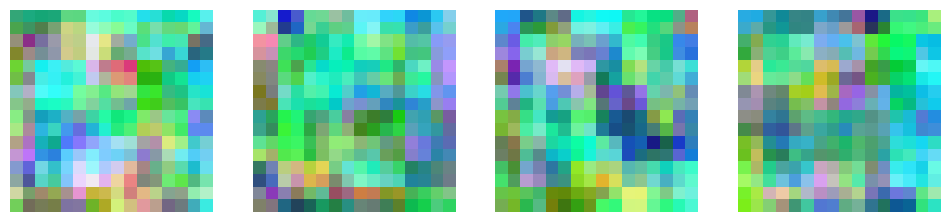

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming fake_images is the output from the generator.
# The generated images are likely in the range [-1, 1] due to the tanh activation.
# Rescale them to [0, 1] for visualization.
def rescale_img(img):
    img = (img + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
    # Clip in case any values fall slightly outside due to numerical issues.
    return np.clip(img, 0, 1)

# Convert the tensor to a numpy array.
fake_images_np = fake_images.numpy()

# Plot each image in the batch.
batch_size = fake_images_np.shape[0]
plt.figure(figsize=(batch_size * 3, 3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    # Rescale the image for display.
    img = rescale_img(fake_images_np[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()
